In [1]:
import os, glob

mask_dir = glob.glob('./masks/*')
print(len(mask_dir))

704


In [2]:
import cv2
import numpy as np
from tqdm import tqdm

width = 224
height = 224

image = []
label = []

task = tqdm(mask_dir)

for mask_path in task:
    if '_mask' in mask_path:
        img_path = mask_path.replace('_mask', '')
        img_path = img_path.replace('masks', 'CXR_png')

        img = cv2.imread(img_path, 0)

        if img is not None:
            mask = cv2.imread(mask_path, 0)
            mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_CUBIC)
            mask = mask.reshape(1, width, height)
            mask = mask / 255
            label.append(mask)

            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
            img = img.reshape(1, width, height)
            img = img / 255
            image.append(img)

image = np.array(image)
label = np.array(label)
print(image.shape, label.shape)

100%|██████████| 704/704 [01:01<00:00, 11.43it/s]
(566, 1, 224, 224)(566, 1, 224, 224)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [4]:
x_train = torch.FloatTensor(image)
y_train = torch.FloatTensor(label)

In [5]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [516, 50])

In [6]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

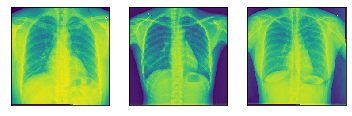

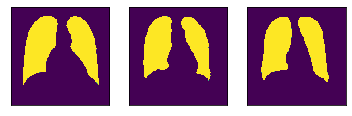

In [8]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()

fig = plt.figure()
img_num = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(1, img_num, i + 1)
    image = image.squeeze()
    ax.imshow(image)
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= img_num:
        break

plt.show()
fig = plt.figure()

for i, image in enumerate(labels):
    bx = fig.add_subplot(1, img_num, i + 1)
    image = image.squeeze()
    bx.imshow(image)
    bx.set_xticks([]), bx.set_yticks([])
    i += 1
    
    if i >= img_num:
        break

plt.show()

In [19]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

In [20]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [21]:
net = UnetGenerator(in_dim=1,out_dim=1,num_filter=16)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


UnetGenerator(
  (down_1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_2): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_2): Max

In [22]:
import torch.optim as optim

criterion = nn.MSELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [23]:
train_losses, val_losses, accuracy = [], [], []
epochs = 50

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        
        with torch.no_grad():
            cnt = 0
            
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_outputs = net(val_image)
                
                val_loss += criterion(val_outputs, val_label)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        lr_scheduler.step(val_loss/len(val_loader))

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} ".format(val_loss/len(val_loader))
             )

print('Finished Training')

Epoch: 1/50 ||Training Loss: 0.14474 ||Val Loss: 0.07973
Epoch: 2/50 ||Training Loss: 0.06115 ||Val Loss: 0.05643
Epoch: 3/50 ||Training Loss: 0.04340 ||Val Loss: 0.04129
Epoch: 4/50 ||Training Loss: 0.03449 ||Val Loss: 0.03524
Epoch: 5/50 ||Training Loss: 0.02945 ||Val Loss: 0.03015
Epoch: 6/50 ||Training Loss: 0.02719 ||Val Loss: 0.03249
Epoch: 7/50 ||Training Loss: 0.02750 ||Val Loss: 0.02846
Epoch: 8/50 ||Training Loss: 0.02465 ||Val Loss: 0.02967
Epoch: 9/50 ||Training Loss: 0.02430 ||Val Loss: 0.02531
Epoch: 10/50 ||Training Loss: 0.02316 ||Val Loss: 0.02553
Epoch: 11/50 ||Training Loss: 0.02143 ||Val Loss: 0.02425
Epoch: 12/50 ||Training Loss: 0.02128 ||Val Loss: 0.02507
Epoch: 13/50 ||Training Loss: 0.02077 ||Val Loss: 0.02301
Epoch: 14/50 ||Training Loss: 0.01965 ||Val Loss: 0.02256
Epoch: 15/50 ||Training Loss: 0.02064 ||Val Loss: 0.03553
Epoch: 16/50 ||Training Loss: 0.02230 ||Val Loss: 0.02083
Epoch: 17/50 ||Training Loss: 0.01903 ||Val Loss: 0.02476
Epoch: 18/50 ||Training

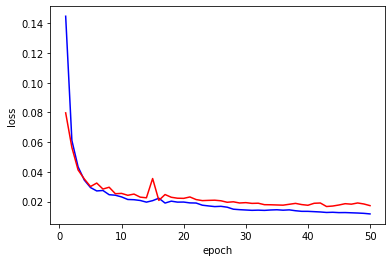

In [24]:
x = np.arange(1, 51, 1)

plt.plot(x, train_losses,'b', label='train loss')
plt.plot(x, val_losses,'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

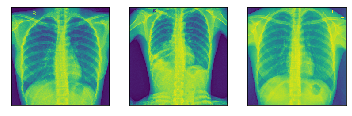

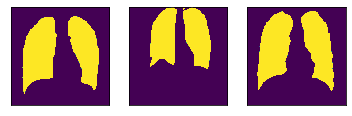

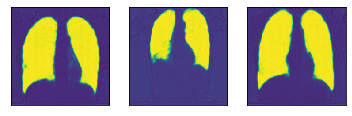

In [30]:
dataiter = iter(val_loader)
images_tensor, labels_tensor = dataiter.next()
images = images_tensor.numpy()
labels = labels_tensor.numpy()

fig = plt.figure()
img_num = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(1, img_num, i + 1)
    image = image.squeeze()
    ax.imshow(image)
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= img_num:
        break

plt.show()
fig = plt.figure()

for i, image in enumerate(labels):
    bx = fig.add_subplot(1, img_num, i + 1)
    image = image.squeeze()
    bx.imshow(image)
    bx.set_xticks([]), bx.set_yticks([])
    i += 1
    
    if i >= img_num:
        break

plt.show()

inputs, labels = images_tensor.to(device), labels_tensor.to(device)
outputs = net(inputs)
show_out = outputs.detach().cpu().numpy()

fig = plt.figure()

for i, image in enumerate(show_out):
    bx = fig.add_subplot(1, img_num, i + 1)
    image = image.squeeze()
    bx.imshow(image)
    bx.set_xticks([]), bx.set_yticks([])
    i += 1
    
    if i >= img_num:
        break